In [5]:
# Importing

import os 
import sys
import pandas as pd
import joblib
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

# Finding the root directory 
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)


import src.utils.file_utils as fu 

cfg_feature_engineering = fu.load_config("feature_engineering")['feature_engineering']
numeric_cols = ['loan_amount', 'income', 'combined_loan_to_value_ratio', 'loan_term', 'intro_rate_period', 'prepayment_penalty_term', 
                'property_value']

In [6]:
# Read processed data file and loading the training data
typed_data = fu.load_parquet("hmda_2024_typed")
train_index_path = os.path.join(project_root, 'data', 'processed', 'train_index.csv')
train_index = pd.read_csv(train_index_path)
train_data = typed_data.loc[train_index['index']]

Loading dataset from C:\Users\emmah\6341_Project\data\interim\hmda_2024_typed.parquet


In [21]:
# Loading the scaler and scaling the numerical values
scaler = joblib.load(os.path.join(project_root, "models", "scaler.pkl"))
X_train_scaled = scaler.transform(train_data[numeric_cols])
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=train_data.index)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train)
X_train_numerical = pd.DataFrame(X_train_imp, columns = X_train.columns, index=X_train.index)

In [34]:
# Loading the OHE variables, mapping from "Yes/No" to binary, and concatenating the datasets 
ohe_cols = ['loan_type', 'loan_purpose', 'construction_method', 'occupancy_type','applicant_sex', 'applicant_sex_observed', 
               'co_applicant_sex', 'co_applicant_sex_observed','applicant_race_observed', 'co_applicant_race_observed',
               'business_or_commercial_purpose', 'co_applicant_age_above_62','interest_only_payment', 'reverse_mortgage', 'submission_of_application']
ohe_df = train_data[ohe_cols].copy()

binary_cols = ['co_applicant_age_above_62', 'interest_only_payment', 'reverse_mortgage', 'submission_of_application']
for col in binary_cols:
    ohe_df[col] = ohe_df[col].map({'Yes':1, 'No':0})
    ohe_df[col] = ohe_df[col].fillna(0)

X_train = pd.concat([X_train_numerical, ohe_df], axis=1)

In [38]:
# Fitting Incremental PCA 
n_components = 22
batch_size = 50000
ipca = IncrementalPCA(n_components=n_components, batch_size = batch_size)
ipca.fit(X_train)

,n_components,22
,whiten,False
,copy,True
,batch_size,50000


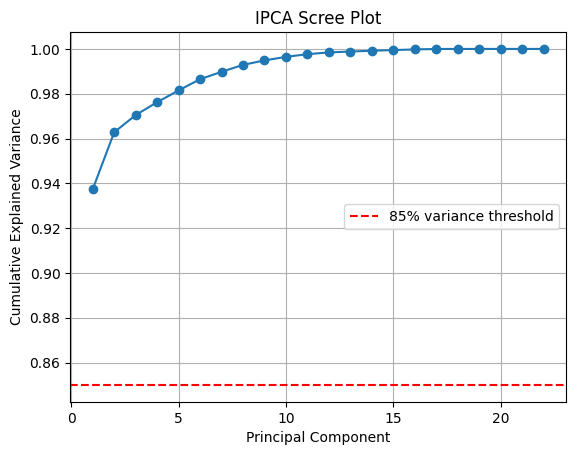

<Figure size 640x480 with 0 Axes>

In [45]:
# Visualizing the Variance 
plt.plot(range(1,ipca.n_components_ +1), ipca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('IPCA Scree Plot')
plt.grid(True)
plt.axhline(y=0.85, color='r', linestyle = '--', label = '85% variance threshold')
plt.legend()
plt.show()

# Saving plot
ipca_plot_path = os.path.join(project_root, 'reports','figures', 'ipca_scree_plot.png')
os.makedirs(os.path.dirname(ipca_path), exist_ok=True)
plt.savefig(ipca_plot_path, dpi=300, bbox_inches='tight')

In [42]:
# Saving the IPCA model 
ipca_path = os.path.join(project_root, 'models','ipca.pkl')
os.makedirs(os.path.dirname(ipca_path), exist_ok=True)
joblib.dump(ipca, ipca_path)

['C:\\Users\\emmah\\6341_Project\\models\\ipca.pkl']

In [47]:
# Creating a CSV of the Explained Variance 
explained_variance = pd.DataFrame({
    'PC' : range(1,ipca.n_components_ +1),
    'ExplainedVarianceRation' : ipca.explained_variance_ratio_,
    'CumulativeVariance': ipca.explained_variance_ratio_.cumsum() })

ipca_csv_path = os.path.join(project_root, 'reports', 'tables', 'pca_variance.csv')
os.makedirs(os.path.dirname(ipca_csv_path), exist_ok=True)
explained_variance.to_csv(ipca_csv_path, index=False)

In [ ]:
# Only need to keep one component. We want to keep the minimum number of components over the 85% threshold.